

---
# Hands-On: Análise de Dados


---


Parte II - ROOT

9. Fazer um ajuste no pico que corresponde ao méson $J/\Psi$ uando o RooFit.

10. Extrair as informações dos parâmetros.

11. Validação do fit (pull e/ou $\chi^{2}/ndof$).










In [1]:
%load_ext autoreload
%autoreload 2

# Instalar: coffea, uproot, awkward

coffea, uproot, e awkward são três bibliotecas importantes para análise de dados em Física de Altas Energias (HEP), especialmente voltadas para trabalhar com arquivos ROOT, que são utilizados no contexto de experimentos no CERN.


* [coffea](https://github.com/CoffeaTeam/coffea
)

* [uproot](https://uproot.readthedocs.io/en/latest/basic.html)

*   [awkward](https://awkward-array.org/doc/main/)

* Ferramentas adicionais:
    * **pandas**: biblioteca para estruturas de dados tabulares e ferramentas de análise em Python.( [documentação do pandas](https://pandas.pydata.org/docs/getting_started/index.html))

  * **numpy**: fornece cálculos numéricos, como criação de histogramas.

  * **matplotlib**: ferramenta comum para criar gráficos, figuras, imagens, visualizações.

  * **vector**: é especializada no trabalho com vetores em 2D, 3D e vetores de Lorentz. Esta biblioteca foi projetada para funcionar com versões do Python 3.8 ou superiores.([documentação do vector](https://vector.readthedocs.io/en/latest/))



In [2]:
try:
  import coffea
except ImportError as e:
  !pip install coffea
  import coffea
print (coffea.__version__)

2024.10.0


In [3]:
#!pip install uproot awkward xrootd
#!pip install fsspec-xrootd
import uproot
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vector
import hist
import mplhep as hep

print (uproot.__version__)
print (ak.__version__)

5.4.1
2.6.9


# Baixar o dataframe criado na Parte I

# Abrir e explorar o arquivo ROOT usando o uproot



* (1.) Abrir o arquivo.
* (2.) Verificar o conteúdo do arquivo.
* (3.) Verificar o conteúdo da TTree: o número de branches, os nomes e os tipos de variáveis em cada branch.

In [4]:
#Usando o output da Parte I ("muon_data_tree.root")
#!wget -nc --no-check-certificate https://eliza.web.cern.ch/eliza/HandsOn/muon_data_tree.root


In [5]:
# Abrir o arquivo ROOT para leitura
file = uproot.open("muon_data_tree.root")


print(file.keys())
tree = file["tree"]
print(tree.keys())  # Lista as branches (colunas)

# Ler algumas entradas para verificar se os dados estão corretos
df_r = tree.arrays(["muon1_pt", "muon1_eta", "muon1_phi", "pt_dimu"], library="pd")  # Carregar em um DataFrame
print(df_r.head())  # Visualizar as primeiras linhas do DataFrame


['tree;1']
['num_final_events', 'muon1_pt', 'muon1_eta', 'muon1_phi', 'muon2_pt', 'muon2_eta', 'muon2_phi', 'pt_dimu', 'eta_dimu', 'mass_dimu']
    muon1_pt  muon1_eta  muon1_phi    pt_dimu
0  52.556774  -1.429199  -2.723145  36.169895
1  50.203129  -0.656128   1.626221  14.304790
2  53.714878   0.159729  -1.947510  29.602020
3  48.502796  -1.802002   1.400146  13.670808
4  43.287487  -0.061668   1.378662   3.742076


In [6]:
#df_r = tree.arrays(tree.keys(), entry_stop=10000, library='pd')
#df_r

In [7]:
len(df_r)

402481

Plotas algumas varáveis cinemáticas do par

In [8]:
'''
plt.figure()
plt.hist(pt_dimu, bins=100, range=(0, 200), histtype='step', color='blue', label=r'$p_T$ (GeV)')
plt.xlabel(r'$p_{T}^{\mu^+\mu^-} [GeV]/c$')
plt.ylabel('Events')
plt.yscale('log')
plt.show()
'''

"\nplt.figure()\nplt.hist(pt_dimu, bins=100, range=(0, 200), histtype='step', color='blue', label=r'$p_T$ (GeV)')\nplt.xlabel(r'$p_{T}^{\\mu^+\\mu^-} [GeV]/c$')\nplt.ylabel('Events')\nplt.yscale('log')\nplt.show()\n"

In [9]:
#
'''
plt.figure()
plt.hist(mass_dimu, bins=3000, range=(0.25, 300), histtype='step', color='blue', linewidth=1.5)
plt.xlabel(r'M$_{\mu^+\mu^-}$ [GeV]/$c^{2}$')
plt.ylabel('Events')
plt.yscale('log')
plt.xscale('log')
plt.show()
'''

"\nplt.figure()\nplt.hist(mass_dimu, bins=3000, range=(0.25, 300), histtype='step', color='blue', linewidth=1.5)\nplt.xlabel(r'M$_{\\mu^+\\mu^-}$ [GeV]/$c^{2}$')\nplt.ylabel('Events')\nplt.yscale('log')\nplt.xscale('log')\nplt.show()\n"

#*Usando o ROOT e a sua ferramenta RooFit*




*   Baixar o Root e obter as dependências;
*   Importar as funções;
*   Com o plot da massa invariante:
  *   Escolher um pico de sinal de física;
  *   Os modelos para o sinal e fundo;
  *   Ajustar aos dados;
  *   Extrair informações;
  *   Validar o ajuste;








In [10]:
%time
#Download ROOT
![ -f root_v6.30.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz ] || wget -nc https://root.cern/download/root_v6.30.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
!tar -xzf root_v6.30.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


In [11]:
%time
#Obtendo todas as dependências necessárias para executar o ROOT no Colab
!sudo apt-get install dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev python3 libssl-dev libafterimage0
import sys
sys.path.append("/content/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/root/lib/libGraf.so')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
gcc is already the newest version (4:11.2.0-1ubuntu1).
libxext-dev is already the newest version (2:1.3.4-1build1).
libxft-dev is already the newest version (2.3.4-1).
libafterimage0 is already the newest version (2.2.12-15).
binutils is already the newest version (2.38-4ubuntu2.6).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
dpkg-dev is already the newest version (1.21.1ubuntu2.3).
libssl-dev is already the newest version (3.0.2-0ubuntu1.18).
libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3).
libxpm-dev is already the newest version (1:3.5.12-1ubuntu0.22.04.2).
python3 is already the newest version (3.10.6-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


<CDLL '/content/root/lib/libGraf.so', handle 5b1f29900f30 at 0x7e35b7fbe980>

In [12]:
import ROOT

Welcome to JupyROOT 6.30/04


In [13]:
# Importar as funções do ROOT aqui
from ROOT import TH1F
from ROOT import TFile
from ROOT import TLorentzVector
from ROOT import TLegend
from ROOT import RooFit
from ROOT import RooDataHist
from ROOT import RooDataSet
from ROOT import RooRealVar
from ROOT import RooArgList
from ROOT import RooArgSet
from ROOT import RooAddPdf
from ROOT import RooExponential
from ROOT import RooGaussian
from ROOT import RooPlot
from ROOT import RooCBShape
from ROOT import RooChi2Var
from ROOT import TLatex


O comando abaixo ativa o processamento multi-thread em ROOT, o que pode acelerar operações que envolvem grandes volumes de dados.

In [14]:
ROOT.ROOT.EnableImplicitMT(4)  # Para usar 4 threads ou

In [15]:
df_r = tree.arrays(["muon1_pt", "muon1_eta", "muon1_phi", "pt_dimu", "mass_dimu"], library="pd")  # Carregar em um DataFrame
print(df_r.head())  # Visualizar as primeiras linhas do DataFrame


    muon1_pt  muon1_eta  muon1_phi    pt_dimu  mass_dimu
0  52.556774  -1.429199  -2.723145  36.169895  91.076653
1  50.203129  -0.656128   1.626221  14.304790  89.062195
2  53.714878   0.159729  -1.947510  29.602020  91.994675
3  48.502796  -1.802002   1.400146  13.670808  91.714264
4  43.287487  -0.061668   1.378662   3.742076  90.336868


In [16]:
# Obter a variável mass_dimu a partir do DataFrame
mass_dimu = df_r["mass_dimu"]

Info in <TCanvas::Print>: png file invariant_mass.png has been created


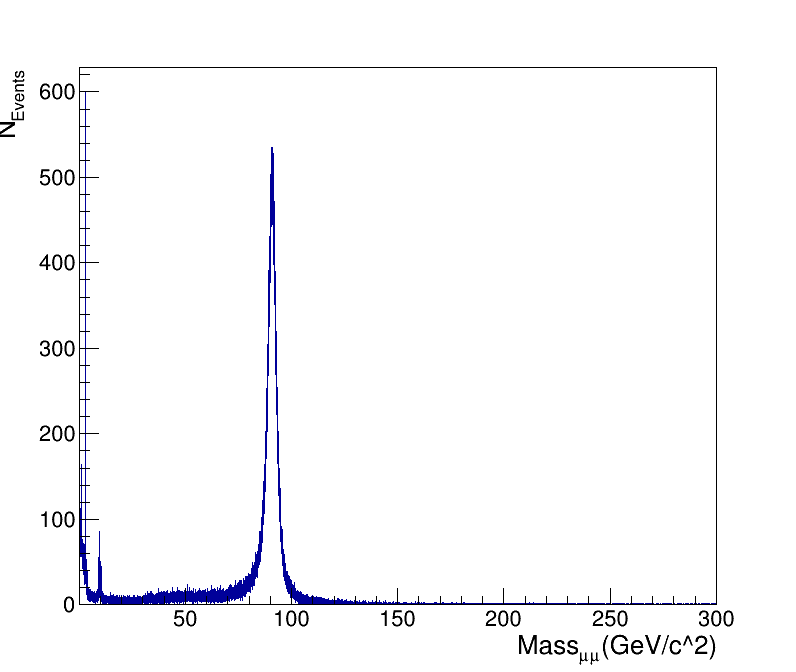

In [17]:
# Nome único para cada execução para evitar conflitos
hist_name = "invariant_mass_histogram"
canvas_name = "invariant_mass_canvas"

# Verifica e remove o histograma existente
if ROOT.gROOT.FindObject(hist_name):
    ROOT.gROOT.FindObject(hist_name).Delete()

# Verifica e remove o canvas existente
if ROOT.gROOT.FindObject(canvas_name):
    ROOT.gROOT.FindObject(canvas_name).Delete()

# Criação do histograma com ROOT
bins = 30000
low = 0.25
up = 300.0
hist = ROOT.TH1F(hist_name, ";Mass_{#mu#mu}(GeV/c^2);N_{Events}",bins , low, up)

hist.GetXaxis().SetTitleSize(0.042)
hist.GetYaxis().SetTitleSize(0.042)
hist.SetStats(False)

# Preenchendo o histograma com os dados de massa invariante
for mass in mass_dimu:
    hist.Fill(mass)

# Criação do canvas e desenho do histograma
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetTextFont(42)
canvas = ROOT.TCanvas(canvas_name, "Invariant Mass", 800, 700)
#canvas1.SetLogx()
#canvas1.SetLogy();
hist.Draw()

# Atualiza o canvas para garantir que o gráfico seja exibido
canvas.Update()
'''
label = ROOT.TLatex()
label.SetTextAlign(22)
#label.DrawLatex(0.55, 3.0e3, "#eta")
label.DrawLatex(0.77, 3.0e3, "#rho,#omega")
label.DrawLatex(1.20, 4.0e3, "#phi")
label.DrawLatex(4.00, 7.0e3, "J/#psi")
label.DrawLatex(4.60, 1.0e3, "#psi'")
label.DrawLatex(13.0, 0.9e3, "Y(1,2,3S)")
label.DrawLatex(91.0, 6.5e3, "Z")
label.SetNDC(True)
label.SetTextAlign(11)
label.SetTextSize(0.03)
label.DrawLatex(0.10, 0.92, "#bf{CMS Open Data}")
label.SetTextAlign(31)
label.DrawLatex(0.90, 0.92, "#sqrt{s} = 13 TeV, L_{int} = 4.7 fb^{-1}");
'''

canvas.Draw()

# Caso queira salvar o resultado
canvas.SaveAs("invariant_mass.png")

In [18]:
#f = TFile("muon_data_tree.root")
#f.ls()


In [19]:
#f.tree.Print()

In [20]:
#max_Events = f.tree.GetEntries()
#max_Events

In [21]:
'''
hist2 = ROOT.TH1F("", ";Mass_{#mu#mu}(GeV/c^2);N_{Events}",bins , low, up)

hist2.GetXaxis().SetTitleSize(0.040)
hist2.GetYaxis().SetTitleSize(0.040)
hist2.SetStats(False)

# Preenchendo o histograma com os dados de massa invariante
for i, mass in enumerate(f.tree):
    hist2.Fill(mass.mass_dimu)
    if i>max_Events:
      break

# Criação do canvas e desenho do histograma
canvas2 = ROOT.TCanvas("canvas2", "Invariant Mass", 800, 700)

hist2.Draw()
# Atualiza o canvas para garantir que o gráfico seja exibido
canvas2.Update()
'''

'\nhist2 = ROOT.TH1F("", ";Mass_{#mu#mu}(GeV/c^2);N_{Events}",bins , low, up)\n\nhist2.GetXaxis().SetTitleSize(0.040)\nhist2.GetYaxis().SetTitleSize(0.040)\nhist2.SetStats(False)\n\n# Preenchendo o histograma com os dados de massa invariante\nfor i, mass in enumerate(f.tree):\n    hist2.Fill(mass.mass_dimu)\n    if i>max_Events:\n      break\n\n# Criação do canvas e desenho do histograma\ncanvas2 = ROOT.TCanvas("canvas2", "Invariant Mass", 800, 700)\n\nhist2.Draw()\n# Atualiza o canvas para garantir que o gráfico seja exibido\ncanvas2.Update()\n'

In [22]:
#Configurar os limites da massa do pico escolhido, como exemplos usaremos o pico do J/Psi
#Com o hist sem o log em y
jpsi_pdg_mass =3.0969 #3096.900/1000
m_min = 2.9
m_max = 3.3
jpsi_bins = int((m_max - m_min)/0.05)
print(jpsi_bins)

# Definindo a variável de massa para RooFit
#Create a Mass variable that RooFit can use, and importing the relevant dataset
mass = ROOT.RooRealVar("mass", "m_{#mu^{+}#mu^{-}}", m_min, m_max, "GeV/c^{2}")
# Convertendo o histograma em um dataset do RooFit
data = ROOT.RooDataHist("data", "dataset with mass", ROOT.RooArgList(mass), hist)


7
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data): fit range of variable mass expanded to nearest bin boundaries: [2.9,3.3] --> [2.89779,3.30745]


In [23]:
## Sinal PDF : Crystal Ball + Gaussian
frac_gauss = ROOT.RooRealVar("frac_gauss", "", 0.4, 0.0, 1.0)
mean = ROOT.RooRealVar("mean", "",jpsi_pdg_mass , m_min, m_max)
sigma_gauss = ROOT.RooRealVar("sigma gauss", "",0.019 , 0.000001, 1.0)

frac_cb = ROOT.RooRealVar("frac_cb", "", 0.6, 0.0, 1.0)
sigma_cb = ROOT.RooRealVar("sigma cb", "",0.019 , 0.000001, 1.0)
alpha = ROOT.RooRealVar("alpha", "",1.4 , 0.0, 10.0)
n = ROOT.RooRealVar("n", "", 20 , 0, 150)
n.setConstant(True)

signal1 = ROOT.RooGaussian("gauss", "", mass, mean, sigma_gauss)
signal2 = ROOT.RooCBShape("crystal ball", "", mass, mean, sigma_cb,alpha,n)


In [24]:
#Background PDF Model
exp_c0 = RooRealVar("exp_c0", "", -3,-5,5)
bkg = ROOT.RooExponential("bkg", "",mass,exp_c0)



In [25]:
model = ROOT.RooAddPdf("model", "", ROOT.RooArgList(signal1,signal2,bkg),ROOT.RooArgList(frac_gauss,frac_cb), ROOT.kTRUE)

In [26]:
fit_result = model.fitTo(data, ROOT.RooFit.Save())

[#0] ERROR:Integration --  RooNumIntFactory::Init : libRooFitMore cannot be loaded. GSL integrators will not beavailable ! 
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (gauss,crystal ball,bkg)
Minuit2Minimizer: Minimize with max-calls 3500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = -8467.16496716641814
Edm   = 6.41661489027254992e-05
Nfcn  = 446
alpha	  = 1.10009	 +/-  0.15264	(limited)
exp_c0	  = -0.959646	 +/-  0.282613	(limited)
frac_cb	  = 0.598532	 +/-  0.0672619	(limited)
frac_gauss	  = 0.439045	 +/-  0.0814887	(limited)
mean	  = 3.0939	 +/-  0.000819427	(limited)
sigma cb	  = 0.022967	 +/-  0.00244335	(limited)
sigma gauss	  = 0.0442406	 +/-  0.00246305	(limited)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


cling::DynamicLibraryManager::loadLibrary(): libgsl.so.27: cannot open shared object file: No such file or directory
Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -7634.385179 Edm =       3541.012602 NCalls =     29
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -7962.394627
  Edm           : 1322.898683
  Internal parameters:	[     -1.137888204    -0.6435011088     0.2013579208    -0.2013579208   -0.01550062071     -1.294241998     -1.294241998]	
  Internal gradient  :	[       253.358997     -284.7008263      379.8827161      458.1292802     -2694.831921     -3344.666881     -7267.468764]	
  Internal covariance matrix:
[[  0.00016711813              0              0              0              0              0              0]
 [            

nr de par: 7
chi sqare: 0.8728039185676764
chi_square/n_param 1.0524988429786686
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (gauss,crystal ball)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
frame_mass_5b1f34273a30[mass] = (::,::,::,::)


Info in <TCanvas::Print>: png file M_JPsi_fit.png has been created


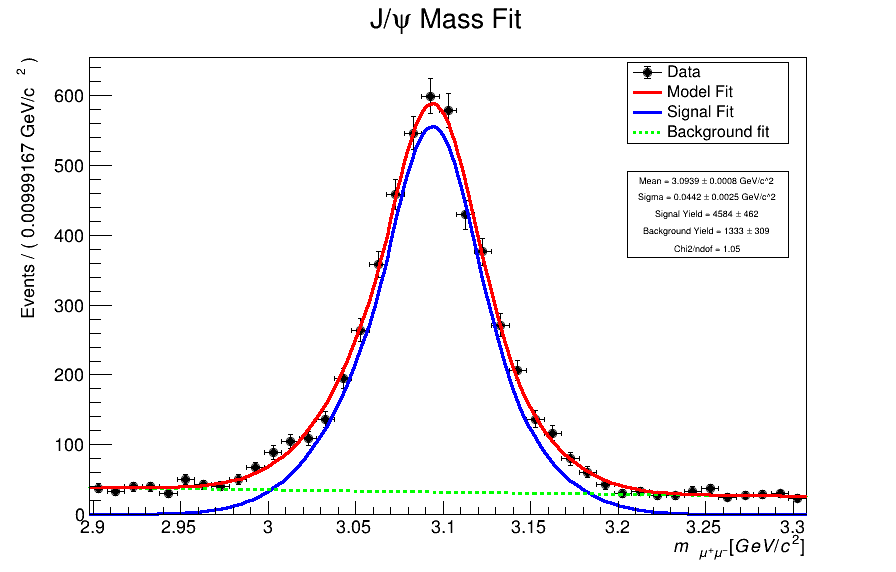

In [27]:
colors = {"model" : 2, "signal" : 4, "background" : 3}
styles = {"model" : 1, "signal" : 1, "background" : 2}

ca = ROOT.TCanvas("can", "",900,600)

frame = mass.frame(ROOT.RooFit.Title("J/#psi Mass Fit"), ROOT.RooFit.Bins(100))
frame.GetXaxis().SetTitle("m_{#\mu^+\mu^-} [GeV/c^2]")

# Data
data.plotOn(frame, ROOT.RooFit.Name("Data"), ROOT.RooFit.DataError(ROOT.RooAbsData.SumW2))

# Signal
model.plotOn(frame, ROOT.RooFit.Name("Signal"), ROOT.RooFit.Components("gauss,crystal ball"), ROOT.RooFit.LineStyle(styles["signal"]), ROOT.RooFit.LineColor(colors["signal"]))

# Background
model.plotOn(frame, ROOT.RooFit.Name("Background"), ROOT.RooFit.Components("bkg"), ROOT.RooFit.LineStyle(styles["background"]), ROOT.RooFit.LineColor(colors["background"]))

# Model
model.plotOn(frame, ROOT.RooFit.Name("Model"), ROOT.RooFit.LineStyle(styles["model"]), ROOT.RooFit.LineColor(colors["model"]))

frame.Print()

# Extraindo os parâmetros ajustados e seus erros
mean_val = mean.getValV()
mean_err = mean.getError()
sigma_val = sigma_gauss.getValV()
sigma_err = sigma_gauss.getError()

import math

# Cálculo do número total de eventos (n_total)
n_total = data.sumEntries()

# Cálculo do yields do sinal
frac_cb_val = frac_cb.getVal()  # Valor de frac_cb
frac_gauss_val = frac_gauss.getVal()  # Valor de frac_gauss
frac_cb_err = frac_cb.getError()
frac_gauss_err = frac_gauss.getError()

# Número de eventos de sinal
nsignal = n_total * (frac_cb_val + (1 - frac_cb_val) * frac_gauss_val)
# Propagação de erros para o sinal
nsignal_err = n_total * math.sqrt((frac_cb_err)**2 + ((1 - frac_cb_val) * frac_gauss_err)**2)

# Número de eventos de fundo (N_total - N_signal)
#nbackground = n_total - nsignal ou N_back = n_total (1 - fgauss) * (1 - fcrystall) * fexponential

nbackground = n_total * (1 - frac_gauss_val) * (1 - frac_cb_val)

# Propagação de erros para o fundo
nbackground_err = n_total * math.sqrt(
    ((1 - frac_cb_val) * frac_gauss_err) ** 2 +
    ((1 - frac_gauss_val) * frac_cb_err) ** 2
)


## ChiSquare computation
n_param = fit_result.floatParsFinal().getSize()
print("nr de par:", n_param)
reduce_chi_square = frame.chiSquare(n_param)
print("chi sqare:", frame.chiSquare() )
print("chi_square/n_param", reduce_chi_square )

frame.Draw()

## Legendas

#legend_text = ROOT.TPaveText(0.65, 0.6, 0.9, 0.85, "NDC")
#legend_text = ROOT.TPaveText(0.75, 0.25, 0.9, 0.35, "NDC")
legend_text = ROOT.TPaveText(0.7, 0.55, 0.88, 0.7, "NDC")
legend_text.AddText(f"Mean = {mean_val:.4f} #pm {mean_err:.4f} GeV/c^2")
legend_text.AddText(f"Sigma = {sigma_val:.4f} #pm {sigma_err:.4f} GeV/c^2")
# Adicionar o rendimento do sinal e do fundo
legend_text.AddText(f"Signal Yield = {nsignal:.0f} #pm {nsignal_err:.0f}")
legend_text.AddText(f"Background Yield = {nbackground:.0f} #pm {nbackground_err:.0f}")
#legend_text.AddText(f"nr de param = {n_param:.2f}")
legend_text.AddText(f"Chi2/ndof = {reduce_chi_square:.2f}")

legend_text.SetFillColor(0)
legend_text.SetBorderSize(1)
legend_text.Draw()

#leg = ROOT.TLegend(0.7, 0.7, 0.88, 0.89)
leg = ROOT.TLegend(0.7, 0.75, 0.88, 0.89)
leg.AddEntry(frame.findObject("Data"), "Data", "LEP")
leg.AddEntry(frame.findObject("Model"), "Model Fit", "L")
leg.AddEntry(frame.findObject("Signal"), "Signal Fit", "L")
leg.AddEntry(frame.findObject("Background"), "Background fit", "L")



leg.Draw("same")
ca.Update()
ca.Draw()

ca.SaveAs("M_JPsi_fit.png")

In [28]:
fit_result.Print()


  RooFitResult: minimized FCN value: -8467.16, estimated distance to minimum: 6.4041e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 alpha    1.1001e+00 +/-  1.54e-01
                exp_c0   -9.5965e-01 +/-  2.85e-01
               frac_cb    5.9853e-01 +/-  7.02e-02
            frac_gauss    4.3904e-01 +/-  8.53e-02
                  mean    3.0939e+00 +/-  8.28e-04
              sigma cb    2.2967e-02 +/-  2.56e-03
           sigma gauss    4.4241e-02 +/-  2.51e-03



O pull é uma medida de quão bem o seu modelo ajustado se alinha com os dados. Para cada bin, o pull representa a diferença entre o valor observado (dados) e o valor previsto pelo ajuste (modelo), normalizado pelo erro. Idealmente, a distribuição de pull deve ser centrada em torno de zero com um desvio padrão próximo de 1.

Mean of Pull: -0.015333352157576542
Sigma (Standard Deviation) of Pull: 0.8888218788082676


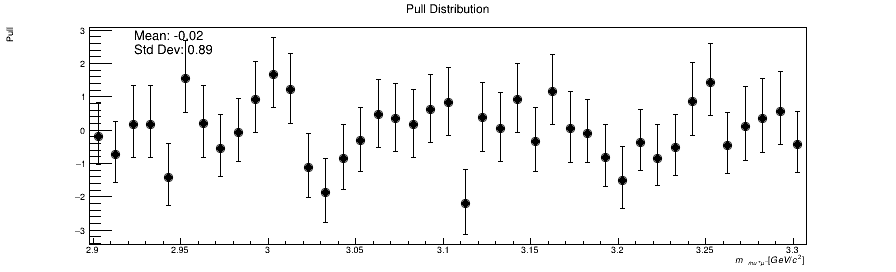

In [29]:
# Crie um frame a partir da variável 'mass' que está sendo ajustada
mass_frame = mass.frame(ROOT.RooFit.Title("Fit Results"))

# Plote os dados no frame
data.plotOn(mass_frame)

# Plote o modelo ajustado no frame
model.plotOn(mass_frame)

# Agora crie o histograma de pulls a partir do gráfico de ajuste
histpull = mass_frame.pullHist()

# Crie um novo frame para a distribuição de pulls
pull_frame = mass.frame(ROOT.RooFit.Title("Pull Distribution"))
pull_frame.addPlotable(histpull, "P")


can2 = ROOT.TCanvas("can2", "Pull Distribution", 900, 300)

# Ajuste o frame para o pull
pull_frame.GetXaxis().SetTitle("m_{#mu^+\mu^-} [GeV/c^2]")
pull_frame.GetYaxis().SetTitle("Pull")
pull_frame.GetYaxis().SetTitleOffset(1.6)

# Desenhe o gráfico de pull
can2.cd()
pull_frame.Draw()

# Calcular o mean e o desvio padrão dos pulls
mean_hist = histpull.GetMean()
stddev_hist = histpull.GetRMS()

mean_pull = np.mean(histpull.GetY())  # Calcula o valor médio (mean) dos pulls
sigma_pull = np.std(histpull.GetY())  # Calcula o desvio padrão (sigma) dos pulls
print(f"Mean of Pull: {mean_pull}")
print(f"Sigma (Standard Deviation) of Pull: {sigma_pull}")
# Adicionando o texto com o mean e o desvio padrão no gráfico de pull
latex = ROOT.TLatex()
latex.SetNDC()  # Para coordenadas normalizadas

# Desenhe o mean e stddev no gráfico
latex.DrawLatex(0.15, 0.85, f"Mean: {mean_pull:.2f}")
latex.DrawLatex(0.15, 0.80, f"Std Dev: {sigma_pull:.2f}")

# Exibir o canvas com a informação correta
can2.Draw()

In [30]:
# Workspace
wspace = ROOT.RooWorkspace("Jpsi fit")

getattr(wspace, "import")(data)
getattr(wspace, "import")(model)

wspace.writeToFile("Jpsi_fit.root")

#ROOT.DisableImplicitMT()

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing dataset data
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooAddPdf::model
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooGaussian::gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::sigma gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::frac_gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooCBShape::crystal ball
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::sigma cb
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::alpha
[#1] INFO:ObjectHandling -- RooWorkspace::import(Jpsi fit) importing RooRealVar::n
[#1] INFO:ObjectHandling -- RooWo